# Random Search for Relative Equilibria

We demonstrate the random search algorithm from Cleary & Page (2023), to compute relative equilibria (REQ) of the point vortex system.

### Initial Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import VorticesMotion as vm
import loss_functions as lf
import velocity_transforms as vt
import newton as nt
import utils
import optax
from functools import partial

import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

/opt/homebrew/Caskroom/miniforge/base/envs/jax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


### Basic Parameters

In [2]:
# --------- Physical Parameters -------------

n = 10           # number of vortices in system
dt = 0.001      # time step
Tf = 10.        # length of trajectory in time units
omega = jnp.pi * 0.5 / Tf      # desired rate of rotation for REQ

gammas = jnp.ones(n)     # set the circulations of each vortex to unity
ind = utils.indices(n)

# --------- Optimiser Parameters -------------

start_learning_rate = 1e-2      # initial learning rate for Adam optimiser
opt_N = 2500                    # maximum number of optimiser steps before abandoning guess
loss_N = 500                    # half the number of time steps integrated over for AD convergence
ad_tol = 1e-3                   # convergence criterion for ad loss function
nr_tol = 1e-10                  # convergence criterion for newton raphson
print_cycle = 100                # how often to print output of AD optimiser

### 1) Generate a Random Guess

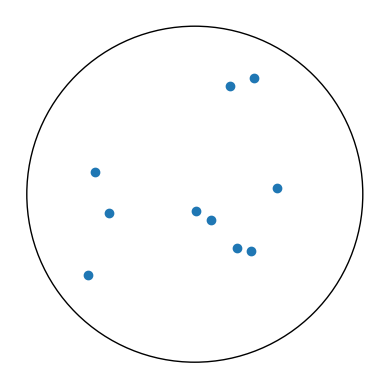

In [3]:
seed = 0
key = jax.random.PRNGKey(seed)
guess = jax.random.uniform(key, (2*n,), minval=0., maxval=1.)

# initially centre the guess on its centre of mass and scale to the desirable average rate of rotation

guess = utils.centre_on_com(guess, gammas)
guess = vt.scale_to_omega(guess, gammas, omega, n, ind)

fig, ax = plt.subplots(1)
ax.scatter(guess[:n], guess[n:])
r_max = jnp.max(jnp.sqrt(guess[:n]**2 + guess[n:]**2))
circle = plt.Circle((0, 0), r_max*1.25, fill=False, color='black')
ax.add_patch(circle)
ax.set_axis_off()
ax.set_box_aspect(1)
plt.show()

### 2) Converge the Random Guess with AD

In [4]:
# define the function to update the initial random guess

@partial(jit, static_argnums=2)
def gradfn(params, gammas, loss_N, omega, indices, alpha):
    return jax.value_and_grad(lf.random_search)(params, gammas, loss_N, omega, indices, alpha)
  
@partial(jit, static_argnums=(3,4))
def updatefn(params, gammas, opt_state, optimizer, loss_N, omega, indices, alpha):

    loss, grads = gradfn(params, gammas, loss_N, omega, indices, alpha)

    updates, opt_state = optimizer.update(grads, opt_state)

    params = optax.apply_updates(params, updates)
  
    return params, opt_state, loss

# set up the optimiser

optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(guess)

# initialise the annealing parameter alpha
alpha = 1.


In [5]:
# Optimisation loop

for i in range(opt_N):

    releq_loss = lf.convergence_check_normalised(guess, gammas, loss_N)

    if i%print_cycle == 0:
        print(i, ": Rel Eq Loss = ", releq_loss, " Delta F = ", vm._return_full_delta_f(guess, gammas, ind, n))


    if releq_loss < ad_tol:
        print(i, ": Rel Eq Loss = ", releq_loss, " Delta F = ", vm._return_full_delta_f(guess, gammas, ind, n))
        print('Converged!')
        break

    guess, opt_state, loss = updatefn(guess, gammas, opt_state, optimizer, loss_N, omega, ind, alpha)

    alpha -= 1./opt_N                                         # anneal alpha
    guess = utils.centre_on_com(guess, gammas)                # recentre on centre of vorticity
    guess = vt.scale_to_omega(guess, gammas, omega, n, ind)   # and scale to desired rate of rotation

0 : Rel Eq Loss =  0.27817048978981784  Delta F =  30.57891006584999
100 : Rel Eq Loss =  0.025742667675714766  Delta F =  0.6238862854166882
200 : Rel Eq Loss =  0.0015288910060818459  Delta F =  0.07279195763473467
219 : Rel Eq Loss =  0.000982657834953844  Delta F =  -0.013452732400168088
Converged!


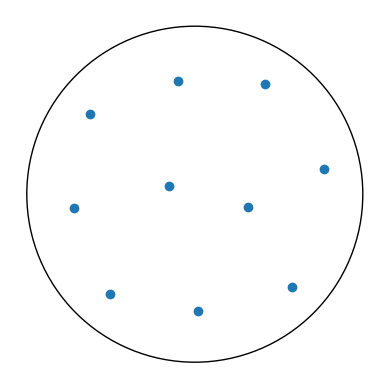

In [6]:
fig, ax = plt.subplots(1)
ax.scatter(guess[:n], guess[n:])
r_max = jnp.max(jnp.sqrt(guess[:n]**2 + guess[n:]**2))
circle = plt.Circle((0, 0), r_max*1.25, fill=False, color='black')
ax.add_patch(circle)
ax.set_axis_off()
ax.set_box_aspect(1)
plt.show()

### 3) Converge with Newton-GMRES-Hookstep Algorithm

In [7]:
# define the time forward map for the Newton method

def rk2_finalT(state, Tf: float):
    """ 2nd order Runge-Kutta method full integrator due to velocities induced by all other vortices """

    eps = dt
    N = jnp.int64(jnp.floor_divide(Tf - eps, dt))

    final_dt = Tf - N * dt

    state = vm._rk2_finalT(state, gammas, ind, N, dt)
    state = vm._rk2_step(state, gammas, ind, final_dt)

    return state

In [8]:
# create the REQ guess object

releq_guess = nt.relEqGuess(guess, Tf, 0.)

guess_T = rk2_finalT(releq_guess.x_init, releq_guess.T)
theta_0 = jnp.arctan2(guess[n:], guess[:n])
theta_T = jnp.arctan2(guess_T[n:], guess_T[:n])
thetadelta = theta_0 - theta_T  # difference in angles
bool_mask = jnp.where(guess[:n]**2 + guess[n:]**2 > 1e-3, jnp.ones(n), jnp.zeros(n))
shiftinit = jnp.mean(thetadelta, where=bool_mask)

releq_guess.shift_init = shiftinit

In [9]:
# converge using the Newton-GMRES-hookstep algorithm

newton_solver = nt.newtonSolver(rk2_finalT, dt, nr_tol, nmax_newt=50, nmax_hook=25)
nr_guess_out = newton_solver.iterate(releq_guess)

Starting Delta =  0.6776354346339443
GMRES residual:  0.0006606273390182722 Iterations:  18
old res:  10.910281245791902 new_res:  5.974111512465216
Current Newton residual:  0.9645827765297318
shift guess:  -0.8624436294267491
GMRES residual:  3.998443910968768e-16 Iterations:  19
old res:  5.974111512465216 new_res:  5.017830268250822
Current Newton residual:  0.6512435640136963
shift guess:  -0.5437516902650745
GMRES residual:  0.0007610933500750095 Iterations:  18
old res:  5.017830268250822 new_res:  1.8046274009874228
Current Newton residual:  0.203862971554275
shift guess:  -0.7106548701843418
GMRES residual:  4.564051094775961e-16 Iterations:  19
old res:  1.8046274009874228 new_res:  0.3067677042711547
Current Newton residual:  0.031151009351491156
shift guess:  -0.7100403349549227
GMRES residual:  2.2614120422652766e-15 Iterations:  19
old res:  0.3067677042711547 new_res:  0.1641916571251458
Current Newton residual:  0.016250663999210126
shift guess:  -0.7091776245495642
GMR

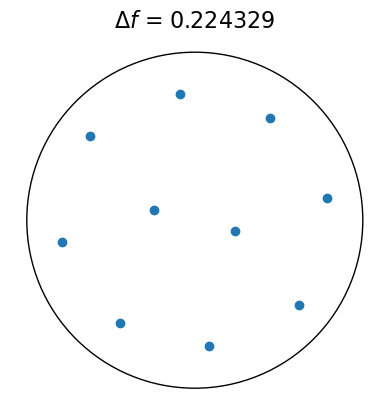

In [10]:
conv_guess = nr_guess_out.x_out

fig, ax = plt.subplots(1)
ax.scatter(conv_guess[:n], conv_guess[n:])
r_max = jnp.max(jnp.sqrt(conv_guess[:n]**2 + conv_guess[n:]**2))
circle = plt.Circle((0, 0), r_max*1.25, fill=False, color='black')
ax.add_patch(circle)
ax.set_axis_off()
ax.set_box_aspect(1)
ax.set_title(f'$\\Delta f$ = {round(vm._return_full_delta_f(conv_guess, gammas, ind, n),6)}', fontsize=16)
plt.show()